## Load Data

In [1]:
!nvidia-smi #py 3.10.11

ERROR: Option #py is not recognized. Please run 'nvidia-smi -h'.



In [2]:
#Count data
import os

# Define the paths to the directories
train_dir = "./../../data/train/"
test_dir = "./../../data/test/"

categories = [
    "ALGAL_LEAF_SPOT",
    "ALLOCARIDARA_ATTACK",
    "HEALTHY_LEAF",
    "LEAF_BLIGHT",
    "PHOMOPSIS_LEAF_SPOT"
]

print("--- Training Set File Counts ---")
for category in categories:
    dir_path = os.path.join(train_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

print("\n--- Test Set File Counts ---")
for category in categories:
    dir_path = os.path.join(test_dir, category)
    try:
        count = len(os.listdir(dir_path))
        print(f"Number of files in {dir_path}: {count}")
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
    except Exception as e:
        print(f"An error occurred for {dir_path}: {e}")

--- Training Set File Counts ---
Number of files in ./../../data/train/ALGAL_LEAF_SPOT: 632
Number of files in ./../../data/train/ALLOCARIDARA_ATTACK: 787
Number of files in ./../../data/train/HEALTHY_LEAF: 841
Number of files in ./../../data/train/LEAF_BLIGHT: 808
Number of files in ./../../data/train/PHOMOPSIS_LEAF_SPOT: 757

--- Test Set File Counts ---
Number of files in ./../../data/test/ALGAL_LEAF_SPOT: 101
Number of files in ./../../data/test/ALLOCARIDARA_ATTACK: 126
Number of files in ./../../data/test/HEALTHY_LEAF: 135
Number of files in ./../../data/test/LEAF_BLIGHT: 129
Number of files in ./../../data/test/PHOMOPSIS_LEAF_SPOT: 121


# Install Timm

In [3]:
# Install Timm (Need to restart the runtime after finish install )
#pip install git+https://github.com/rwightman/pytorch-image-models.git
#%pip install lightning transformers datasets evaluate pillow 

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split, Dataset

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import StratifiedKFold,KFold

from lightning.fabric import Fabric

from copy import copy

import shutil
import torchvision.transforms as transforms

from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets

## visualization Model

In [5]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [6]:
# Select model (List of available is shown above)
resnet50 = "resnet50"
resnet50_model= timm.create_model(resnet50, pretrained=True, num_classes=5)
# Print a summary using torchinfo (uncomment for actual output)
summary(model=resnet50_model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

d:\Coding\Python\Project\durianLeaf\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ahmad\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 5]              --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (act1)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [7]:
# Transform image data based on ImageNet's mean and std
data_transforms = { # เปลี่ยนชื่อตัวแปรเป็น data_transforms
    "train": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
}

In [8]:
dataset = datasets.ImageFolder(root=train_dir,
                               transform=data_transforms["train"], 
                               target_transform=None)

In [9]:
dataset.class_to_idx

{'ALGAL_LEAF_SPOT': 0,
 'ALLOCARIDARA_ATTACK': 1,
 'HEALTHY_LEAF': 2,
 'LEAF_BLIGHT': 3,
 'PHOMOPSIS_LEAF_SPOT': 4}

In [10]:
len(dataset)

3825

In [11]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
#Select Model
model_name = "resnet50"

In [13]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

# Cross Validation Configuration
k_splits = 5
metric = evaluate.load("accuracy")

In [14]:
# Cross validation
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

In [15]:
# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 16
eval_batch_size = 8
num_accumulate = 1

In [16]:
torch.set_float32_matmul_precision('high')
#fabric = Fabric(accelerator="cuda", precision="16-mixed")
fabric = Fabric(accelerator="gpu", devices=1, precision="16-mixed")
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)


In [17]:
import time

In [18]:
%%time
all_eval_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1} of {k_splits}")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=5)


    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
    # optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)    # update the slow weight every k steps
                                                                   # update the optimizer by combine slow weight and fast weight * alpha

    model, optimizer = fabric.setup(model, optimizer)

    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    train_dataloader, val_dataloader = fabric.setup_dataloaders(train_dataloader, val_dataloader)

    # Reset Model Info
    info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
        "best_val_loss": 999,
    }

    for epoch in range(num_epochs):
        train_loss_epoch = []
        val_loss_epoch = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        num_updates = epoch * len(train_dataloader)

        ### === Train Loop === ###
        ## Time
        s1 = time.time()

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            # inputs = {k: v.to(device) for k,v in inputs.items()}
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            fabric.backward(loss)

            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
        ### ==================== ###

        # optimizer.sync_lookahead()              # Sync slow weight and fast weight
        scheduler.step(epoch + 1)

        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                # inputs = {k: v.to(device) for k,v in inputs.items()}
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        ## Time train finish
        s2 = time.time()
        elapsed_time = s2 - s1


        # Log Data
        metric_train = metric.compute(predictions=train_preds, references=train_targets)["accuracy"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets)["accuracy"]

        info["metric_train"].append(metric_train)
        info["metric_val"].append(metric_val)

        info["train_loss"].append(np.average(train_loss_epoch))
        info["val_loss"].append(np.average(val_loss_epoch))

        if metric_val > info["best_metric_val"]:
        # if info["val_loss"][-1] < info["best_val_loss"]:
            print("New Best Score!")
            # print("New Best Val Loss")
            info["best_metric_val"] = metric_val
            # info["best_val_loss"] = info["val_loss"][-1]
            torch.save(model, f"resnet50_checkpoint_fold{fold}.pt")

        print(f"Using time of Fold: {fold} | Epoch: {epoch} | {elapsed_time} second ")
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

    # save all best metric val
    all_eval_scores.append(info["best_metric_val"])

Fold 1 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 0 | 48.20361089706421 second 
{'metric_train': [0.6483660130718955], 'metric_val': [0.8862745098039215], 'train_loss': [np.float64(0.9605182056160023)], 'val_loss': [np.float64(0.35373921750821563)], 'best_metric_val': 0.8862745098039215, 'best_val_loss': 999}
Fold: 0 | Epoch: 0 | Metric: 0.8862745098039215 | Training Loss: 0.9605182056160023 | Validation Loss: 0.35373921750821563


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 1 | 47.51417660713196 second 
{'metric_train': [0.6483660130718955, 0.9098039215686274], 'metric_val': [0.8862745098039215, 0.9267973856209151], 'train_loss': [np.float64(0.9605182056160023), np.float64(0.27341869867329177)], 'val_loss': [np.float64(0.35373921750821563), np.float64(0.22789531578018796)], 'best_metric_val': 0.9267973856209151, 'best_val_loss': 999}
Fold: 0 | Epoch: 1 | Metric: 0.9267973856209151 | Training Loss: 0.27341869867329177 | Validation Loss: 0.22789531578018796


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 2 | 48.151556968688965 second 
{'metric_train': [0.6483660130718955, 0.9098039215686274, 0.9705882352941176], 'metric_val': [0.8862745098039215, 0.9267973856209151, 0.9633986928104575], 'train_loss': [np.float64(0.9605182056160023), np.float64(0.27341869867329177), np.float64(0.10469517093588365)], 'val_loss': [np.float64(0.35373921750821563), np.float64(0.22789531578018796), np.float64(0.1235286971577807)], 'best_metric_val': 0.9633986928104575, 'best_val_loss': 999}
Fold: 0 | Epoch: 2 | Metric: 0.9633986928104575 | Training Loss: 0.10469517093588365 | Validation Loss: 0.1235286971577807


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 0 | Epoch: 3 | 46.609928131103516 second 
{'metric_train': [0.6483660130718955, 0.9098039215686274, 0.9705882352941176, 0.984313725490196], 'metric_val': [0.8862745098039215, 0.9267973856209151, 0.9633986928104575, 0.9607843137254902], 'train_loss': [np.float64(0.9605182056160023), np.float64(0.27341869867329177), np.float64(0.10469517093588365), np.float64(0.060452885754178474)], 'val_loss': [np.float64(0.35373921750821563), np.float64(0.22789531578018796), np.float64(0.1235286971577807), np.float64(0.12236449669611223)], 'best_metric_val': 0.9633986928104575, 'best_val_loss': 999}
Fold: 0 | Epoch: 3 | Metric: 0.9607843137254902 | Training Loss: 0.060452885754178474 | Validation Loss: 0.12236449669611223


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 0 | Epoch: 4 | 47.14598035812378 second 
{'metric_train': [0.6483660130718955, 0.9098039215686274, 0.9705882352941176, 0.984313725490196, 0.9879084967320262], 'metric_val': [0.8862745098039215, 0.9267973856209151, 0.9633986928104575, 0.9607843137254902, 0.9647058823529412], 'train_loss': [np.float64(0.9605182056160023), np.float64(0.27341869867329177), np.float64(0.10469517093588365), np.float64(0.060452885754178474), np.float64(0.047927113106197794)], 'val_loss': [np.float64(0.35373921750821563), np.float64(0.22789531578018796), np.float64(0.1235286971577807), np.float64(0.12236449669611223), np.float64(0.12715841444454176)], 'best_metric_val': 0.9647058823529412, 'best_val_loss': 999}
Fold: 0 | Epoch: 4 | Metric: 0.9647058823529412 | Training Loss: 0.047927113106197794 | Validation Loss: 0.12715841444454176
Fold 2 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 0 | 46.07049536705017 second 
{'metric_train': [0.6496732026143791], 'metric_val': [0.8862745098039215], 'train_loss': [np.float64(0.9327520032723745)], 'val_loss': [np.float64(0.35104042941262986)], 'best_metric_val': 0.8862745098039215, 'best_val_loss': 999}
Fold: 1 | Epoch: 0 | Metric: 0.8862745098039215 | Training Loss: 0.9327520032723745 | Validation Loss: 0.35104042941262986


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 1 | 46.40246033668518 second 
{'metric_train': [0.6496732026143791, 0.9205882352941176], 'metric_val': [0.8862745098039215, 0.9241830065359478], 'train_loss': [np.float64(0.9327520032723745), np.float64(0.2488937148009427)], 'val_loss': [np.float64(0.35104042941262986), np.float64(0.2013955381771666)], 'best_metric_val': 0.9241830065359478, 'best_val_loss': 999}
Fold: 1 | Epoch: 1 | Metric: 0.9241830065359478 | Training Loss: 0.2488937148009427 | Validation Loss: 0.2013955381771666


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 2 | 47.226486682891846 second 
{'metric_train': [0.6496732026143791, 0.9205882352941176, 0.9725490196078431], 'metric_val': [0.8862745098039215, 0.9241830065359478, 0.9398692810457516], 'train_loss': [np.float64(0.9327520032723745), np.float64(0.2488937148009427), np.float64(0.10354505457022849)], 'val_loss': [np.float64(0.35104042941262986), np.float64(0.2013955381771666), np.float64(0.17457849752736365)], 'best_metric_val': 0.9398692810457516, 'best_val_loss': 999}
Fold: 1 | Epoch: 2 | Metric: 0.9398692810457516 | Training Loss: 0.10354505457022849 | Validation Loss: 0.17457849752736365


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 1 | Epoch: 3 | 49.44196653366089 second 
{'metric_train': [0.6496732026143791, 0.9205882352941176, 0.9725490196078431, 0.9872549019607844], 'metric_val': [0.8862745098039215, 0.9241830065359478, 0.9398692810457516, 0.954248366013072], 'train_loss': [np.float64(0.9327520032723745), np.float64(0.2488937148009427), np.float64(0.10354505457022849), np.float64(0.048531529697356746)], 'val_loss': [np.float64(0.35104042941262986), np.float64(0.2013955381771666), np.float64(0.17457849752736365), np.float64(0.14009638203151553)], 'best_metric_val': 0.954248366013072, 'best_val_loss': 999}
Fold: 1 | Epoch: 3 | Metric: 0.954248366013072 | Training Loss: 0.048531529697356746 | Validation Loss: 0.14009638203151553


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 1 | Epoch: 4 | 47.40662956237793 second 
{'metric_train': [0.6496732026143791, 0.9205882352941176, 0.9725490196078431, 0.9872549019607844, 0.9892156862745098], 'metric_val': [0.8862745098039215, 0.9241830065359478, 0.9398692810457516, 0.954248366013072, 0.954248366013072], 'train_loss': [np.float64(0.9327520032723745), np.float64(0.2488937148009427), np.float64(0.10354505457022849), np.float64(0.048531529697356746), np.float64(0.04141373345555621)], 'val_loss': [np.float64(0.35104042941262986), np.float64(0.2013955381771666), np.float64(0.17457849752736365), np.float64(0.14009638203151553), np.float64(0.13075128046511963)], 'best_metric_val': 0.954248366013072, 'best_val_loss': 999}
Fold: 1 | Epoch: 4 | Metric: 0.954248366013072 | Training Loss: 0.04141373345555621 | Validation Loss: 0.13075128046511963
Fold 3 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 0 | 47.12040615081787 second 
{'metric_train': [0.6310457516339869], 'metric_val': [0.9084967320261438], 'train_loss': [np.float64(0.9486965999240056)], 'val_loss': [np.float64(0.27003290366459015)], 'best_metric_val': 0.9084967320261438, 'best_val_loss': 999}
Fold: 2 | Epoch: 0 | Metric: 0.9084967320261438 | Training Loss: 0.9486965999240056 | Validation Loss: 0.27003290366459015


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 1 | 49.334028244018555 second 
{'metric_train': [0.6310457516339869, 0.9202614379084967], 'metric_val': [0.9084967320261438, 0.9437908496732026], 'train_loss': [np.float64(0.9486965999240056), np.float64(0.2465460048406385)], 'val_loss': [np.float64(0.27003290366459015), np.float64(0.1735985239395935)], 'best_metric_val': 0.9437908496732026, 'best_val_loss': 999}
Fold: 2 | Epoch: 1 | Metric: 0.9437908496732026 | Training Loss: 0.2465460048406385 | Validation Loss: 0.1735985239395935


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 2 | Epoch: 2 | 49.17915606498718 second 
{'metric_train': [0.6310457516339869, 0.9202614379084967, 0.9643790849673203], 'metric_val': [0.9084967320261438, 0.9437908496732026, 0.9464052287581699], 'train_loss': [np.float64(0.9486965999240056), np.float64(0.2465460048406385), np.float64(0.12171855772127553)], 'val_loss': [np.float64(0.27003290366459015), np.float64(0.1735985239395935), np.float64(0.14510329660455076)], 'best_metric_val': 0.9464052287581699, 'best_val_loss': 999}
Fold: 2 | Epoch: 2 | Metric: 0.9464052287581699 | Training Loss: 0.12171855772127553 | Validation Loss: 0.14510329660455076


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 2 | Epoch: 3 | 48.737066984176636 second 
{'metric_train': [0.6310457516339869, 0.9202614379084967, 0.9643790849673203, 0.9836601307189542], 'metric_val': [0.9084967320261438, 0.9437908496732026, 0.9464052287581699, 0.9450980392156862], 'train_loss': [np.float64(0.9486965999240056), np.float64(0.2465460048406385), np.float64(0.12171855772127553), np.float64(0.05769241464561977)], 'val_loss': [np.float64(0.27003290366459015), np.float64(0.1735985239395935), np.float64(0.14510329660455076), np.float64(0.17463208347544423)], 'best_metric_val': 0.9464052287581699, 'best_val_loss': 999}
Fold: 2 | Epoch: 3 | Metric: 0.9450980392156862 | Training Loss: 0.05769241464561977 | Validation Loss: 0.17463208347544423


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

Using time of Fold: 2 | Epoch: 4 | 47.22393083572388 second 
{'metric_train': [0.6310457516339869, 0.9202614379084967, 0.9643790849673203, 0.9836601307189542, 0.992483660130719], 'metric_val': [0.9084967320261438, 0.9437908496732026, 0.9464052287581699, 0.9450980392156862, 0.9450980392156862], 'train_loss': [np.float64(0.9486965999240056), np.float64(0.2465460048406385), np.float64(0.12171855772127553), np.float64(0.05769241464561977), np.float64(0.03391337352028737)], 'val_loss': [np.float64(0.27003290366459015), np.float64(0.1735985239395935), np.float64(0.14510329660455076), np.float64(0.17463208347544423), np.float64(0.20232490675759132)], 'best_metric_val': 0.9464052287581699, 'best_val_loss': 999}
Fold: 2 | Epoch: 4 | Metric: 0.9450980392156862 | Training Loss: 0.03391337352028737 | Validation Loss: 0.20232490675759132
Fold 4 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 0 | 46.425817012786865 second 
{'metric_train': [0.6529411764705882], 'metric_val': [0.8849673202614379], 'train_loss': [np.float64(0.9366668205475435)], 'val_loss': [np.float64(0.31832096716001007)], 'best_metric_val': 0.8849673202614379, 'best_val_loss': 999}
Fold: 3 | Epoch: 0 | Metric: 0.8849673202614379 | Training Loss: 0.9366668205475435 | Validation Loss: 0.31832096716001007


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 1 | 47.43636727333069 second 
{'metric_train': [0.6529411764705882, 0.9147058823529411], 'metric_val': [0.8849673202614379, 0.918954248366013], 'train_loss': [np.float64(0.9366668205475435), np.float64(0.28115770733954076)], 'val_loss': [np.float64(0.31832096716001007), np.float64(0.23793668661043435)], 'best_metric_val': 0.918954248366013, 'best_val_loss': 999}
Fold: 3 | Epoch: 1 | Metric: 0.918954248366013 | Training Loss: 0.28115770733954076 | Validation Loss: 0.23793668661043435


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 2 | 47.7886118888855 second 
{'metric_train': [0.6529411764705882, 0.9147058823529411, 0.9607843137254902], 'metric_val': [0.8849673202614379, 0.918954248366013, 0.938562091503268], 'train_loss': [np.float64(0.9366668205475435), np.float64(0.28115770733954076), np.float64(0.13152102616004413)], 'val_loss': [np.float64(0.31832096716001007), np.float64(0.23793668661043435), np.float64(0.18633593321889444)], 'best_metric_val': 0.938562091503268, 'best_val_loss': 999}
Fold: 3 | Epoch: 2 | Metric: 0.938562091503268 | Training Loss: 0.13152102616004413 | Validation Loss: 0.18633593321889444


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 3 | 49.52586317062378 second 
{'metric_train': [0.6529411764705882, 0.9147058823529411, 0.9607843137254902, 0.9833333333333333], 'metric_val': [0.8849673202614379, 0.918954248366013, 0.938562091503268, 0.9477124183006536], 'train_loss': [np.float64(0.9366668205475435), np.float64(0.28115770733954076), np.float64(0.13152102616004413), np.float64(0.060303997223551654)], 'val_loss': [np.float64(0.31832096716001007), np.float64(0.23793668661043435), np.float64(0.18633593321889444), np.float64(0.1593547553998178)], 'best_metric_val': 0.9477124183006536, 'best_val_loss': 999}
Fold: 3 | Epoch: 3 | Metric: 0.9477124183006536 | Training Loss: 0.060303997223551654 | Validation Loss: 0.1593547553998178


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 3 | Epoch: 4 | 48.08640122413635 second 
{'metric_train': [0.6529411764705882, 0.9147058823529411, 0.9607843137254902, 0.9833333333333333, 0.9888888888888889], 'metric_val': [0.8849673202614379, 0.918954248366013, 0.938562091503268, 0.9477124183006536, 0.9490196078431372], 'train_loss': [np.float64(0.9366668205475435), np.float64(0.28115770733954076), np.float64(0.13152102616004413), np.float64(0.060303997223551654), np.float64(0.04797032661857278)], 'val_loss': [np.float64(0.31832096716001007), np.float64(0.23793668661043435), np.float64(0.18633593321889444), np.float64(0.1593547553998178), np.float64(0.15181797838886268)], 'best_metric_val': 0.9490196078431372, 'best_val_loss': 999}
Fold: 3 | Epoch: 4 | Metric: 0.9490196078431372 | Training Loss: 0.04797032661857278 | Validation Loss: 0.15181797838886268
Fold 5 of 5


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 0 | 49.36753439903259 second 
{'metric_train': [0.6388888888888888], 'metric_val': [0.8509803921568627], 'train_loss': [np.float64(0.9518672098250439)], 'val_loss': [np.float64(0.46689461025137763)], 'best_metric_val': 0.8509803921568627, 'best_val_loss': 999}
Fold: 4 | Epoch: 0 | Metric: 0.8509803921568627 | Training Loss: 0.9518672098250439 | Validation Loss: 0.46689461025137763


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 1 | 47.34315371513367 second 
{'metric_train': [0.6388888888888888, 0.9127450980392157], 'metric_val': [0.8509803921568627, 0.9163398692810457], 'train_loss': [np.float64(0.9518672098250439), np.float64(0.26448461851881194)], 'val_loss': [np.float64(0.46689461025137763), np.float64(0.24835762239915007)], 'best_metric_val': 0.9163398692810457, 'best_val_loss': 999}
Fold: 4 | Epoch: 1 | Metric: 0.9163398692810457 | Training Loss: 0.26448461851881194 | Validation Loss: 0.24835762239915007


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 2 | 45.585575580596924 second 
{'metric_train': [0.6388888888888888, 0.9127450980392157, 0.9666666666666667], 'metric_val': [0.8509803921568627, 0.9163398692810457, 0.9294117647058824], 'train_loss': [np.float64(0.9518672098250439), np.float64(0.26448461851881194), np.float64(0.11516748395418593)], 'val_loss': [np.float64(0.46689461025137763), np.float64(0.24835762239915007), np.float64(0.20703651436087966)], 'best_metric_val': 0.9294117647058824, 'best_val_loss': 999}
Fold: 4 | Epoch: 2 | Metric: 0.9294117647058824 | Training Loss: 0.11516748395418593 | Validation Loss: 0.20703651436087966


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 3 | 45.20039367675781 second 
{'metric_train': [0.6388888888888888, 0.9127450980392157, 0.9666666666666667, 0.9830065359477124], 'metric_val': [0.8509803921568627, 0.9163398692810457, 0.9294117647058824, 0.938562091503268], 'train_loss': [np.float64(0.9518672098250439), np.float64(0.26448461851881194), np.float64(0.11516748395418593), np.float64(0.0508801057136831)], 'val_loss': [np.float64(0.46689461025137763), np.float64(0.24835762239915007), np.float64(0.20703651436087966), np.float64(0.1988201331508511)], 'best_metric_val': 0.938562091503268, 'best_val_loss': 999}
Fold: 4 | Epoch: 3 | Metric: 0.938562091503268 | Training Loss: 0.0508801057136831 | Validation Loss: 0.1988201331508511


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

New Best Score!
Using time of Fold: 4 | Epoch: 4 | 46.75729990005493 second 
{'metric_train': [0.6388888888888888, 0.9127450980392157, 0.9666666666666667, 0.9830065359477124, 0.9915032679738562], 'metric_val': [0.8509803921568627, 0.9163398692810457, 0.9294117647058824, 0.938562091503268, 0.9437908496732026], 'train_loss': [np.float64(0.9518672098250439), np.float64(0.26448461851881194), np.float64(0.11516748395418593), np.float64(0.0508801057136831), np.float64(0.03895766750550441)], 'val_loss': [np.float64(0.46689461025137763), np.float64(0.24835762239915007), np.float64(0.20703651436087966), np.float64(0.1988201331508511), np.float64(0.18078200389754784)], 'best_metric_val': 0.9437908496732026, 'best_val_loss': 999}
Fold: 4 | Epoch: 4 | Metric: 0.9437908496732026 | Training Loss: 0.03895766750550441 | Validation Loss: 0.18078200389754784
CPU times: total: 1min 42s
Wall time: 19min 56s


In [19]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

Evaluating Fold 0:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


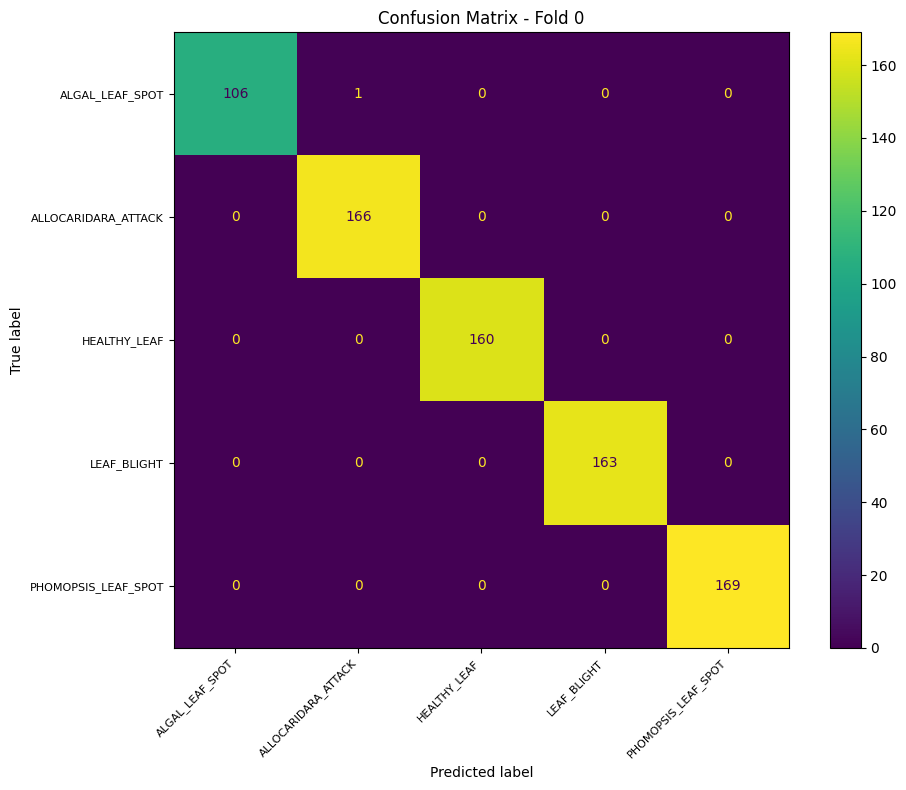

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      0.99      1.00       107
ALLOCARIDARA_ATTACK       0.99      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


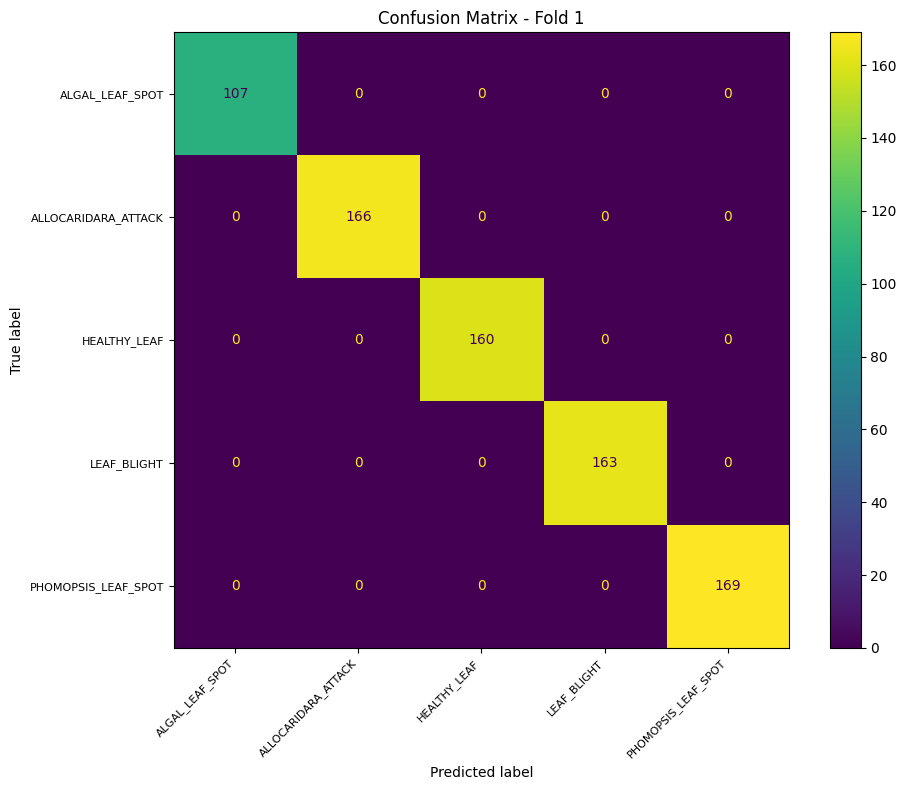

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       1.00      1.00      1.00       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      1.00      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      1.00      1.00       169

           accuracy                           1.00       765
          macro avg       1.00      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


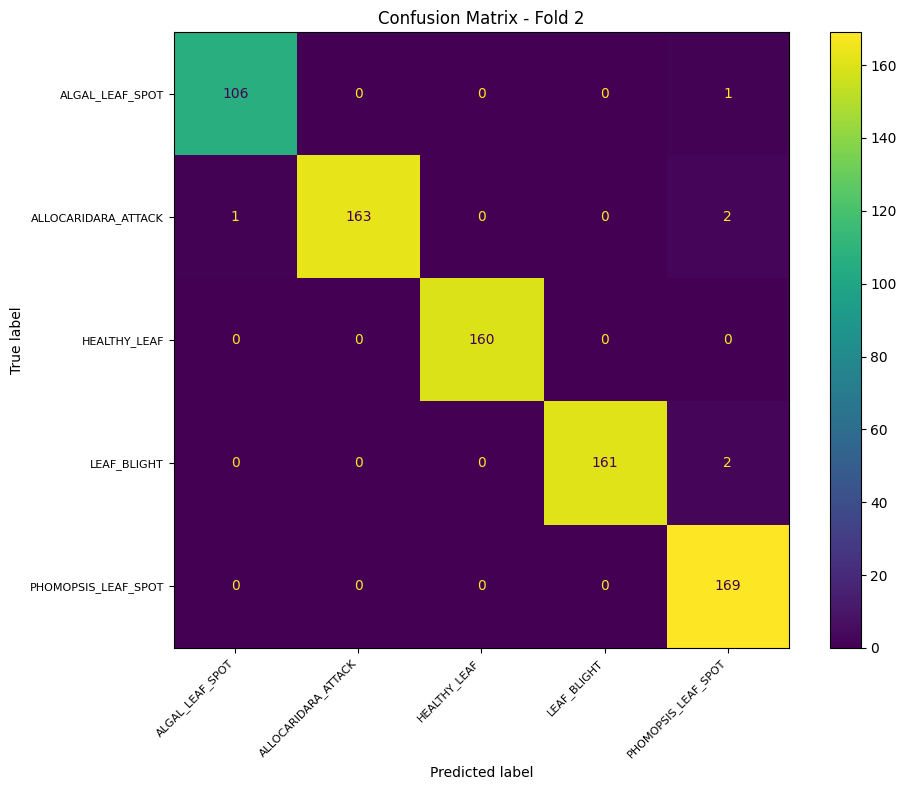

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.99      0.99      0.99       107
ALLOCARIDARA_ATTACK       1.00      0.98      0.99       166
       HEALTHY_LEAF       1.00      1.00      1.00       160
        LEAF_BLIGHT       1.00      0.99      0.99       163
PHOMOPSIS_LEAF_SPOT       0.97      1.00      0.99       169

           accuracy                           0.99       765
          macro avg       0.99      0.99      0.99       765
       weighted avg       0.99      0.99      0.99       765

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


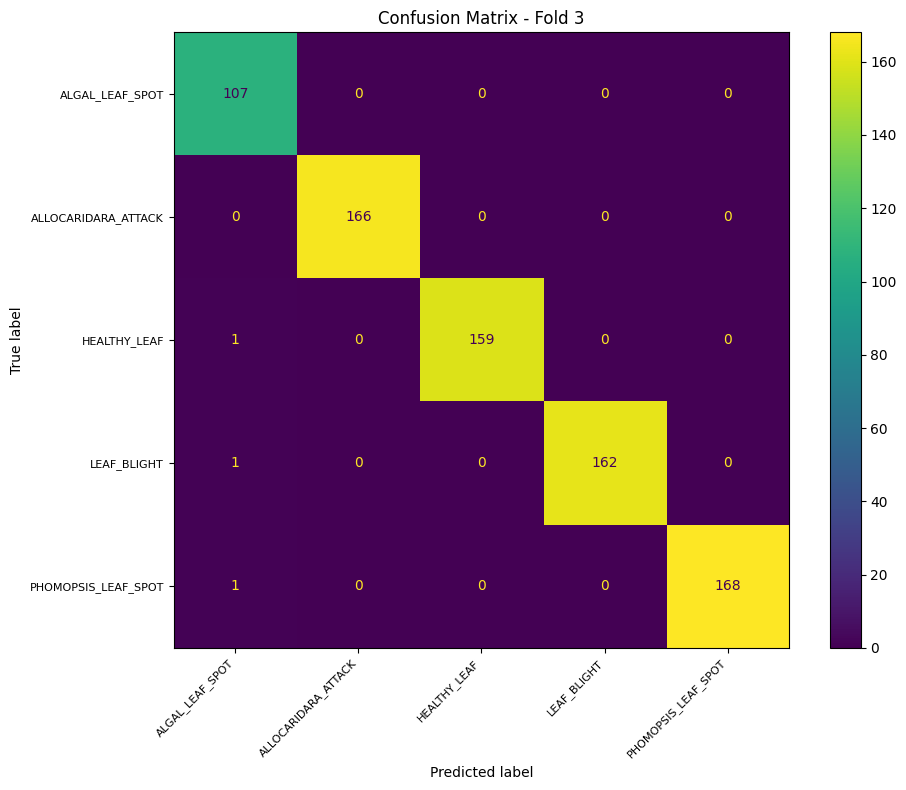

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.97      1.00      0.99       107
ALLOCARIDARA_ATTACK       1.00      1.00      1.00       166
       HEALTHY_LEAF       1.00      0.99      1.00       160
        LEAF_BLIGHT       1.00      0.99      1.00       163
PHOMOPSIS_LEAF_SPOT       1.00      0.99      1.00       169

           accuracy                           1.00       765
          macro avg       0.99      1.00      1.00       765
       weighted avg       1.00      1.00      1.00       765

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/96 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


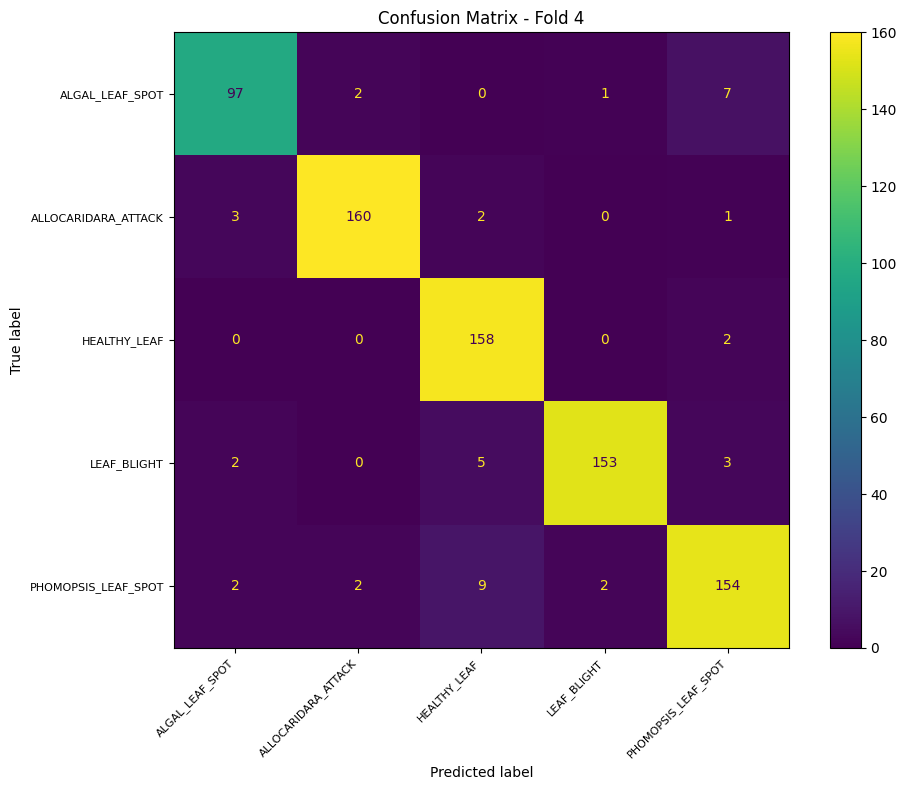

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.93      0.91      0.92       107
ALLOCARIDARA_ATTACK       0.98      0.96      0.97       166
       HEALTHY_LEAF       0.91      0.99      0.95       160
        LEAF_BLIGHT       0.98      0.94      0.96       163
PHOMOPSIS_LEAF_SPOT       0.92      0.91      0.92       169

           accuracy                           0.94       765
          macro avg       0.94      0.94      0.94       765
       weighted avg       0.94      0.94      0.94       765

--------------------------------------------------


In [20]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"resnet50_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

In [21]:
classname = dataset.classes
classname

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [22]:
# Making Dataset
test_dataset = datasets.ImageFolder(root=test_dir,
                               transform=data_transforms["test"], # ใช้ data_transforms แทน
                               target_transform=None)# transforms to perform on labels (if necessary)

In [23]:
len(test_dataset)

612

In [24]:
# Making test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [25]:
test_dataset.classes

['ALGAL_LEAF_SPOT',
 'ALLOCARIDARA_ATTACK',
 'HEALTHY_LEAF',
 'LEAF_BLIGHT',
 'PHOMOPSIS_LEAF_SPOT']

In [26]:
len(test_dataloader)

77

Evaluating Fold 0:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 0 ---


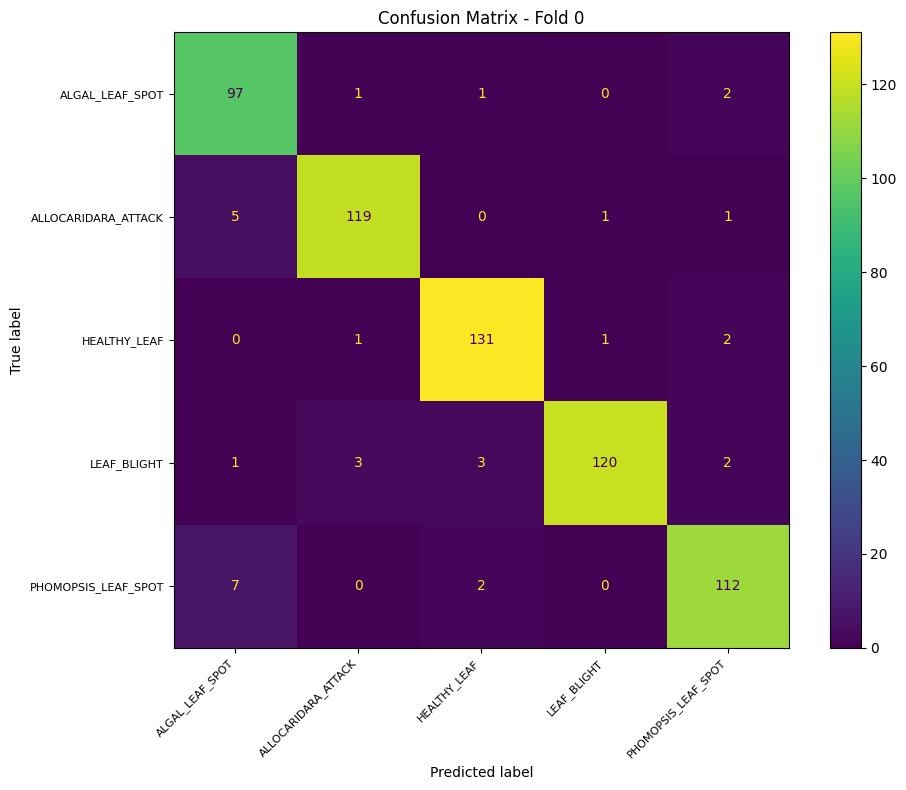

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.88      0.96      0.92       101
ALLOCARIDARA_ATTACK       0.96      0.94      0.95       126
       HEALTHY_LEAF       0.96      0.97      0.96       135
        LEAF_BLIGHT       0.98      0.93      0.96       129
PHOMOPSIS_LEAF_SPOT       0.94      0.93      0.93       121

           accuracy                           0.95       612
          macro avg       0.94      0.95      0.94       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 1:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 1 ---


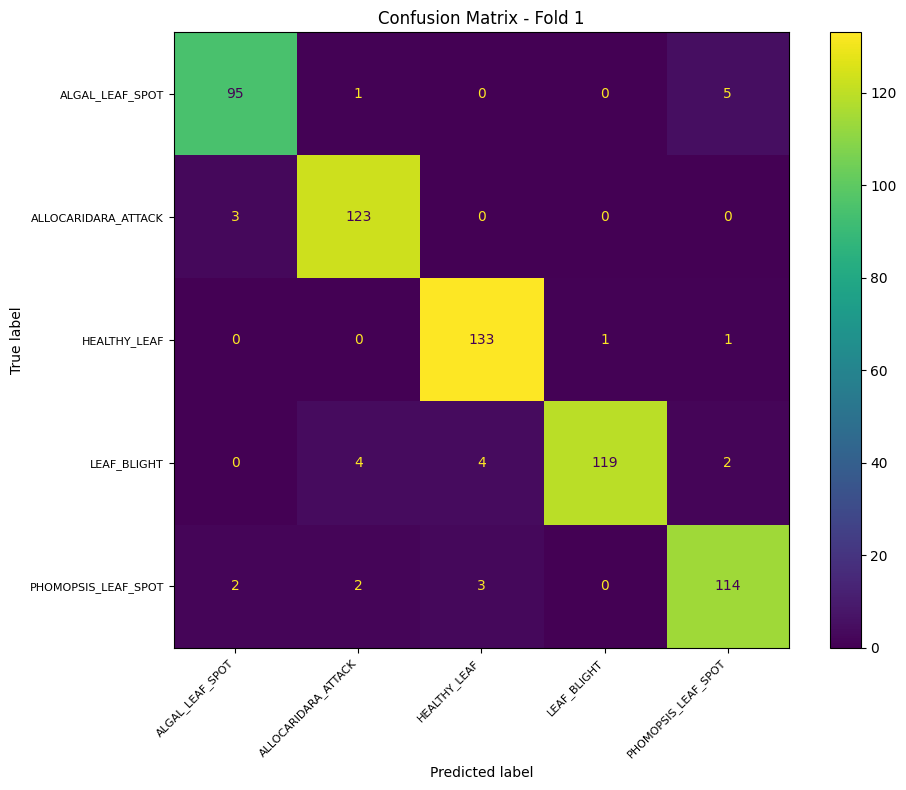

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.95      0.94      0.95       101
ALLOCARIDARA_ATTACK       0.95      0.98      0.96       126
       HEALTHY_LEAF       0.95      0.99      0.97       135
        LEAF_BLIGHT       0.99      0.92      0.96       129
PHOMOPSIS_LEAF_SPOT       0.93      0.94      0.94       121

           accuracy                           0.95       612
          macro avg       0.95      0.95      0.95       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 2:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 2 ---


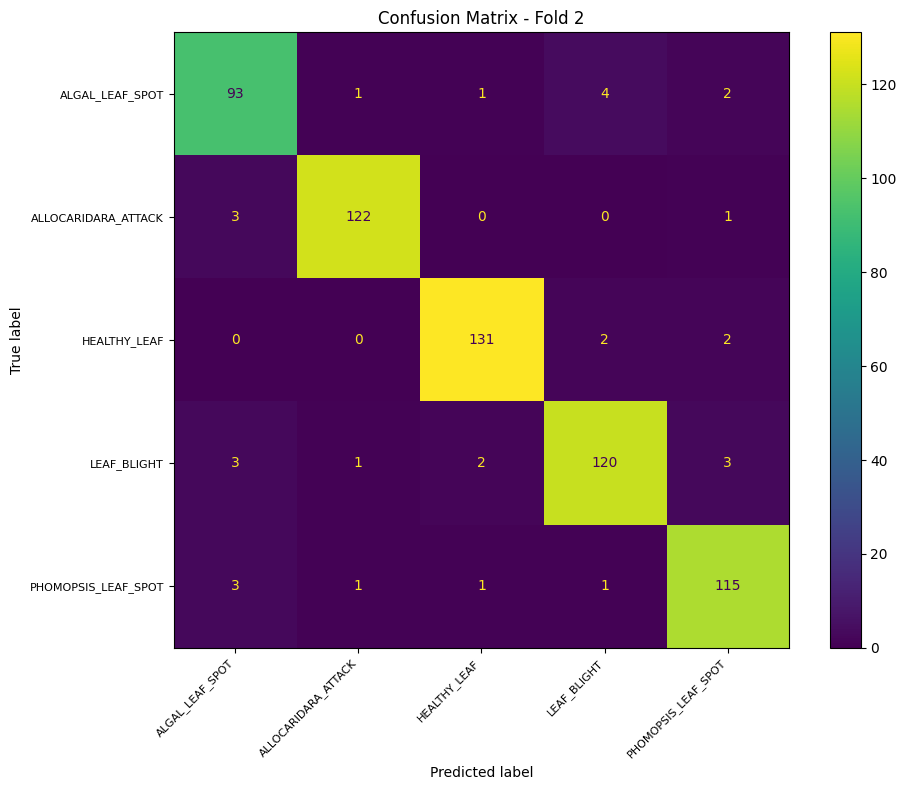

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.91      0.92      0.92       101
ALLOCARIDARA_ATTACK       0.98      0.97      0.97       126
       HEALTHY_LEAF       0.97      0.97      0.97       135
        LEAF_BLIGHT       0.94      0.93      0.94       129
PHOMOPSIS_LEAF_SPOT       0.93      0.95      0.94       121

           accuracy                           0.95       612
          macro avg       0.95      0.95      0.95       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 3:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 3 ---


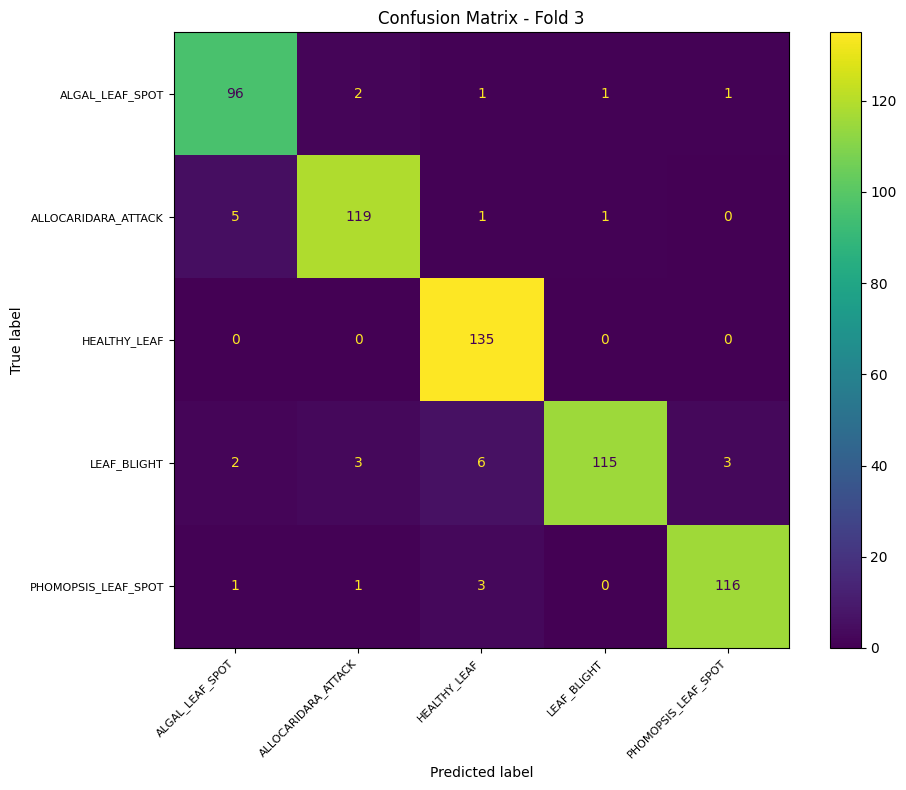

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.92      0.95      0.94       101
ALLOCARIDARA_ATTACK       0.95      0.94      0.95       126
       HEALTHY_LEAF       0.92      1.00      0.96       135
        LEAF_BLIGHT       0.98      0.89      0.93       129
PHOMOPSIS_LEAF_SPOT       0.97      0.96      0.96       121

           accuracy                           0.95       612
          macro avg       0.95      0.95      0.95       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


Evaluating Fold 4:   0%|          | 0/77 [00:00<?, ?it/s]


--- Results for Fold: 4 ---


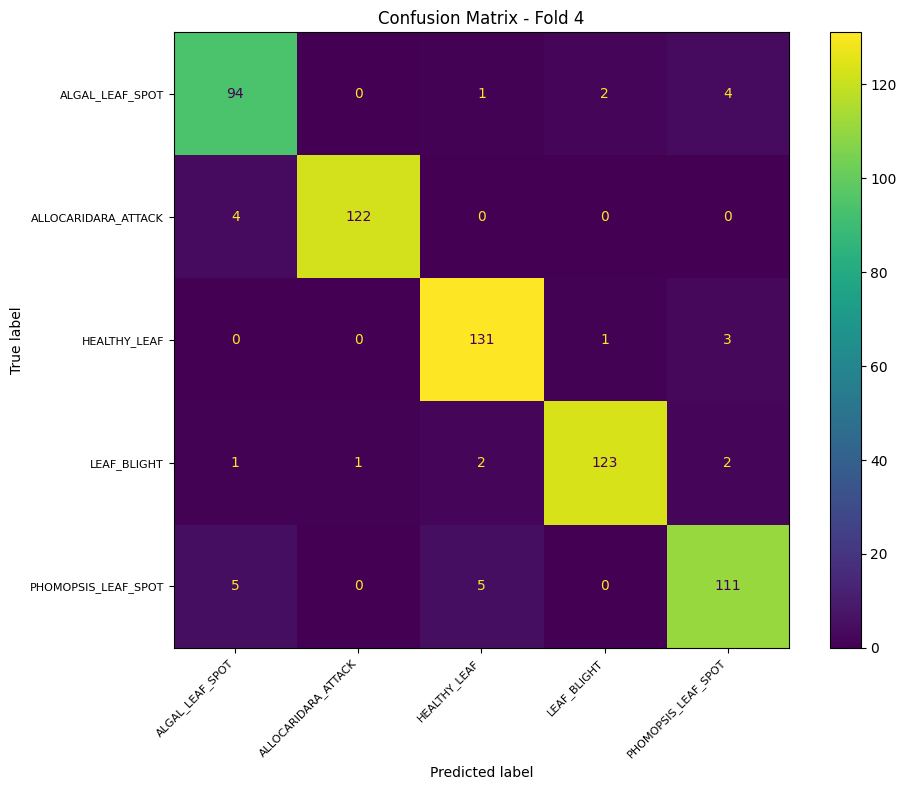

                     precision    recall  f1-score   support

    ALGAL_LEAF_SPOT       0.90      0.93      0.92       101
ALLOCARIDARA_ATTACK       0.99      0.97      0.98       126
       HEALTHY_LEAF       0.94      0.97      0.96       135
        LEAF_BLIGHT       0.98      0.95      0.96       129
PHOMOPSIS_LEAF_SPOT       0.93      0.92      0.92       121

           accuracy                           0.95       612
          macro avg       0.95      0.95      0.95       612
       weighted avg       0.95      0.95      0.95       612

--------------------------------------------------


In [27]:
for fold in range(k_splits):
    predictions = []
    references = []

    loaded_model = torch.load(f"resnet50_checkpoint_fold{fold}.pt", weights_only=False)
    loaded_model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluating Fold {fold}"):
            inputs, targets = batch
            outputs = loaded_model(inputs.to(device))

            predictions += outputs.argmax(-1).detach().cpu().tolist()
            references += targets.tolist()

    print(f"\n--- Results for Fold: {fold} ---")

    cm = confusion_matrix(references, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classname)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.show()

    print(classification_report(references, predictions, target_names=classname))
    print("-" * 50) #

## Visualization train model result

In [28]:
## Making Pridcition return class & prob
from typing import List, Tuple

from PIL import Image
def pred_class(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: T = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    classname =  class_names[target_image_pred_label]
    prob = target_image_pred_probs.max().cpu().numpy()

    return classname , prob

In [29]:
##Load some model
loaded_model = torch.load('resnet50_checkpoint_fold0.pt', weights_only=False)

## Train data visulization

In [30]:
#Making df for rando
import os
import pandas as pd
from PIL import Image

# create an empty list to store image paths
image_paths = []

# loop through each subfolder in the "Image" directory
for root, dirs, files in os.walk("./../../data/test/"):
    for subfolder_name in dirs:
        # get the path to the subfolder
        subfolder_path = os.path.join(root, subfolder_name)
        # loop through each file in the subfolder
        for filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, filename)
            image_paths.append((image_path, subfolder_name))

# create a DataFrame from the list of image paths
df = pd.DataFrame(image_paths, columns=['path', 'subfolder_name'])


In [39]:
df.sample(10)

path       subfolder_name
319   ./../../data/test/HEALTHY_LEAF\to_label_2395.jpg         HEALTHY_LEAF
250   ./../../data/test/HEALTHY_LEAF\to_label_1871.jpg         HEALTHY_LEAF
310   ./../../data/test/HEALTHY_LEAF\to_label_2303.jpg         HEALTHY_LEAF
279   ./../../data/test/HEALTHY_LEAF\to_label_2109.jpg         HEALTHY_LEAF
503  ./../../data/test/PHOMOPSIS_LEAF_SPOT\to_label...  PHOMOPSIS_LEAF_SPOT
587  ./../../data/test/PHOMOPSIS_LEAF_SPOT\to_label...  PHOMOPSIS_LEAF_SPOT
12   ./../../data/test/ALGAL_LEAF_SPOT\to_label_172...      ALGAL_LEAF_SPOT
278   ./../../data/test/HEALTHY_LEAF\to_label_2098.jpg         HEALTHY_LEAF
379    ./../../data/test/LEAF_BLIGHT\to_label_2792.jpg          LEAF_BLIGHT
550  ./../../data/test/PHOMOPSIS_LEAF_SPOT\to_label...  PHOMOPSIS_LEAF_SPOT

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def sample_picture(df=df,random_state=None):
    # Sample 20 random rows from the DataFrame
    sample_df = df.sample(20, random_state=random_state).copy()
    sample_df = sample_df.reset_index(drop=True)
    # Define the grid layout for displaying the images
    num_rows = 4
    num_cols = 5
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
    fig.tight_layout(pad=5.0)

    # Iterate over the sampled rows and display the images in the grid
    for i, row in sample_df.iterrows():
        img = Image.open(row['path'])

        # Prediction
        pred_name , prob = pred_class(model=loaded_model,image_path=row['path'],
                   class_names = classname,
                   transform=data_transforms["test"])

        row_idx = i // num_cols
        col_idx = i % num_cols
        axs[row_idx, col_idx].imshow(img)
        axs[row_idx, col_idx].axis('on')
        axs[row_idx, col_idx].set_title(row['subfolder_name'] + ': \nPredict:' + pred_name + '\nProb:'+ str(prob.round(decimals=2)) )

        # prediction


    plt.show()

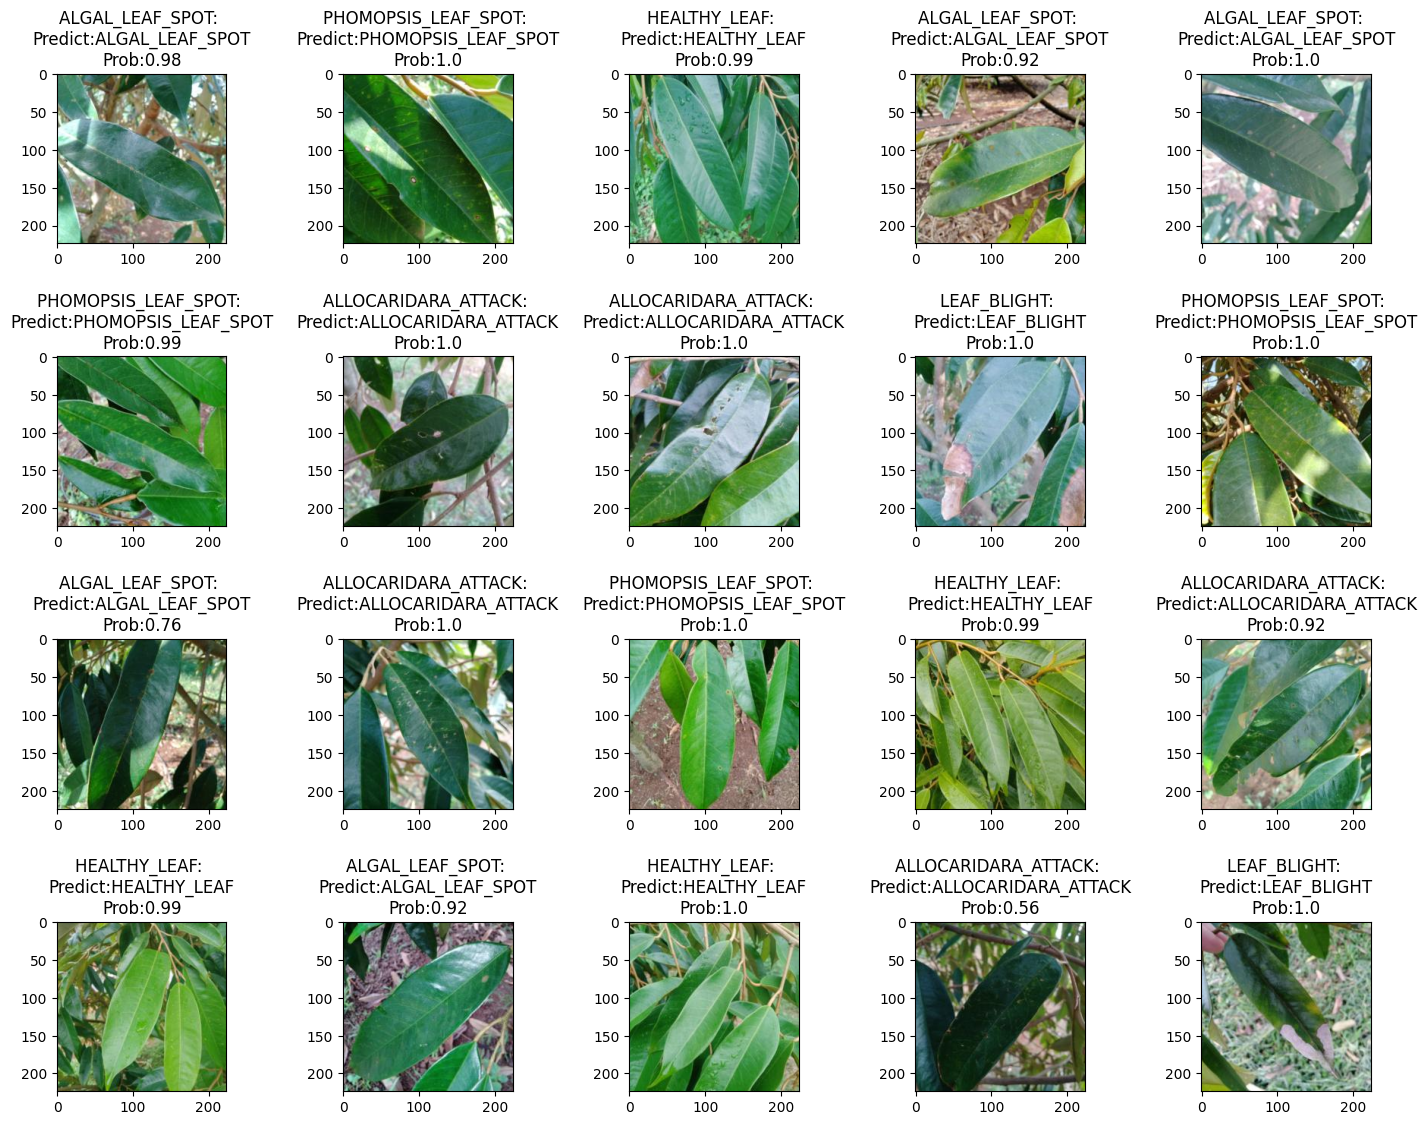

In [33]:
sample_picture()

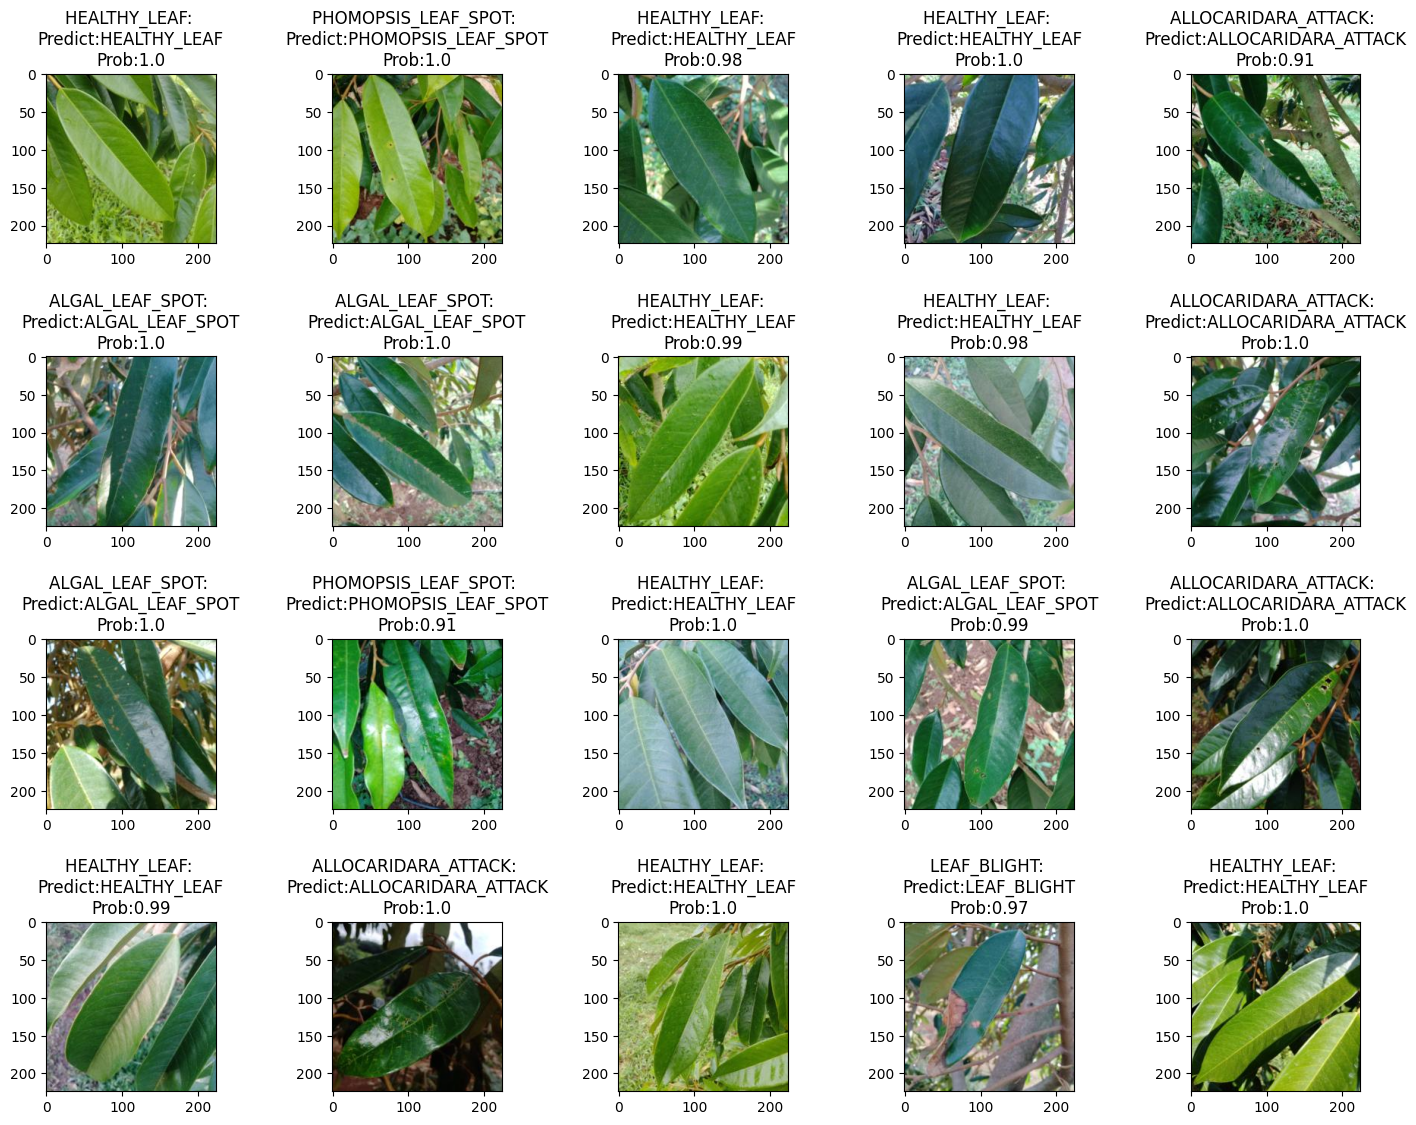

In [34]:
sample_picture()

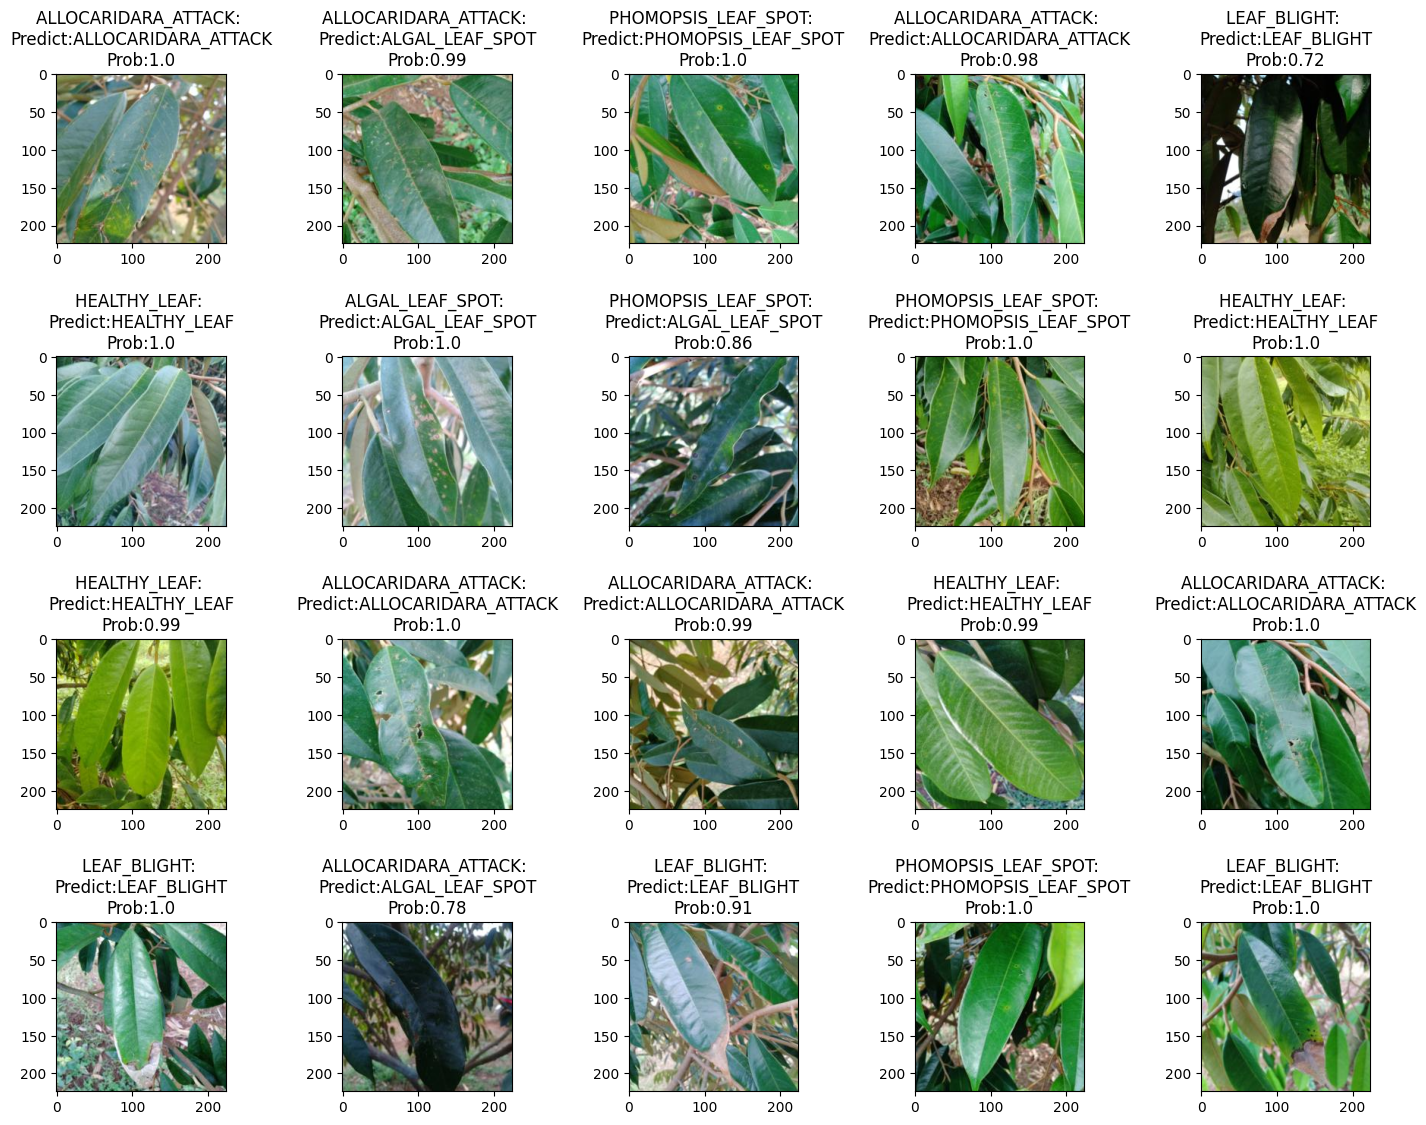

In [35]:
sample_picture()

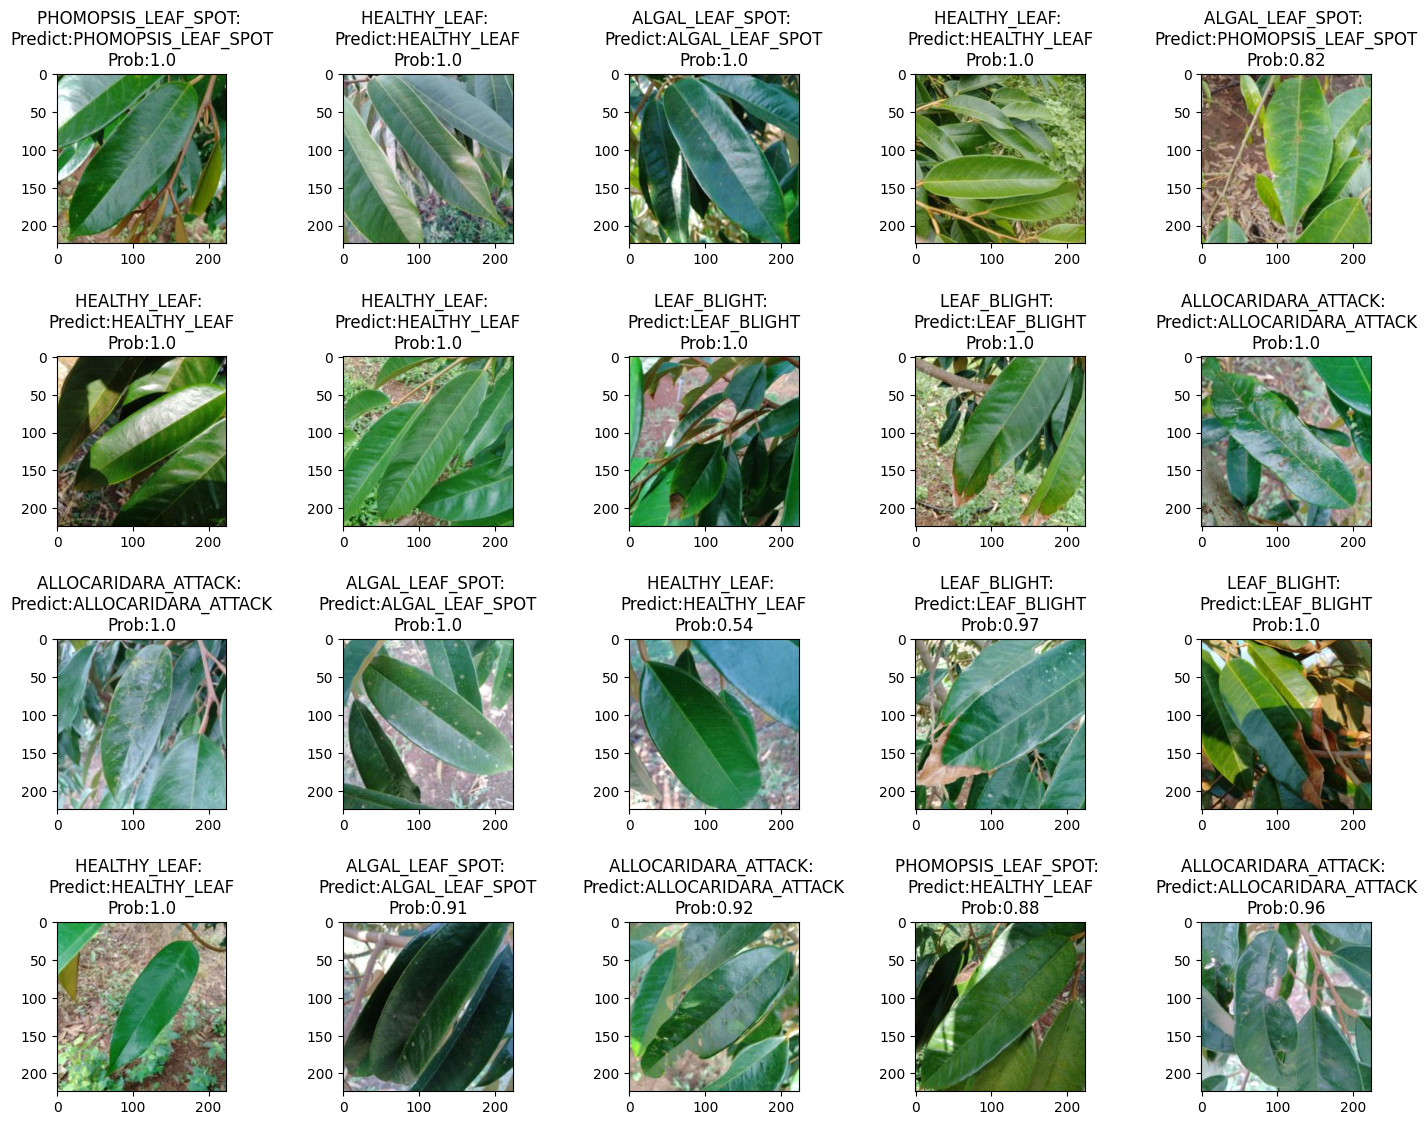

In [36]:
sample_picture()

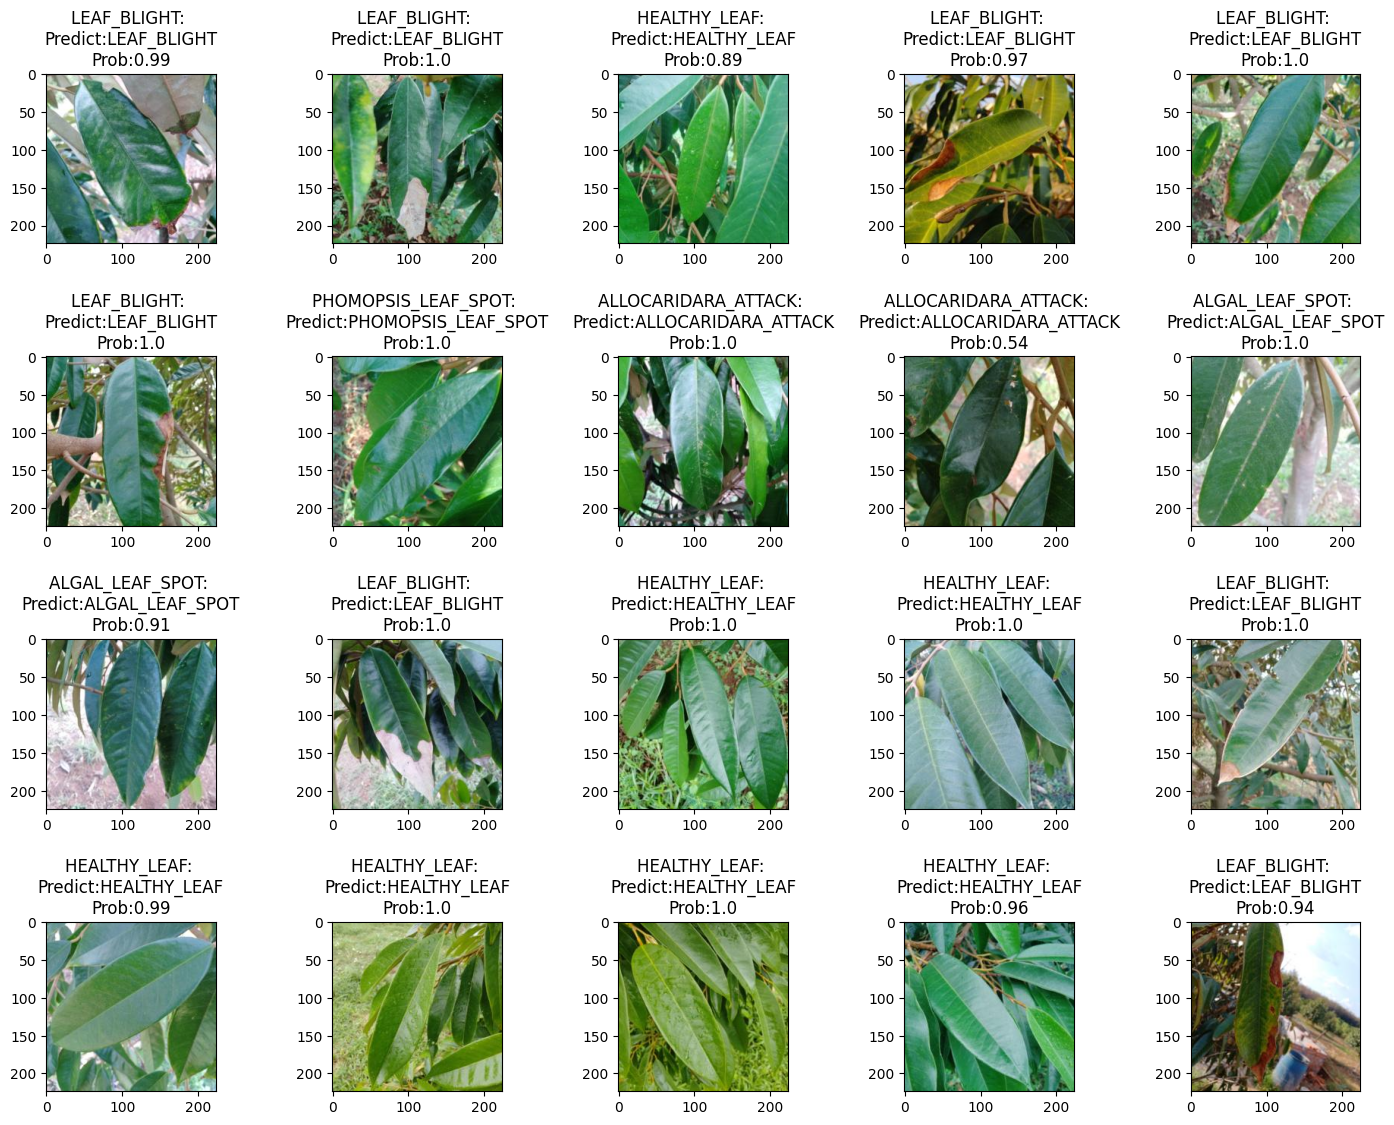

In [37]:
sample_picture()